In [12]:
import pandas as pd
import numpy as np
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import matthews_corrcoef

from pandas.plotting import scatter_matrix
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns



%matplotlib inline
pylab.rcParams['figure.figsize'] = 12,8

In [13]:
df = pd.read_csv("processed_loans_2007.csv")
#print(df.columns)
df.drop(["Unnamed: 0"],axis=1, inplace=True) #drop index from the last export on cleaning steps
print(df.columns)
df.shape

Index(['loan_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc',
       'loan_status', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'term_ 36 months',
       'term_ 60 months'],
      dtype='object')


(37675, 38)

In [14]:
df.loan_status.value_counts(normalize=True)

1    0.856961
0    0.143039
Name: loan_status, dtype: float64

It seems that we have a problem with class imbalance. Therefore, it's not a good idea to just train it with the normal accuracy benchmarks. That would be superficially high and would not be helpful in our predictions. This is a good example if we decide to use high recall(true positive) and low fallout (false positive) rates for evaluation; a testament in which accuracy would fail.

Ie:

True positive rate = (True postives)/(True positives + false negatives).
False positive rate = (false positives)/(false positive + true negatives).

# Exloratory Analysis

In [15]:
#which columns correlated the best to the loan status (Y/N)
df.corr()["loan_status"].sort_values()

int_rate                              -0.210814
term_ 60 months                       -0.171194
revol_util                            -0.099547
purpose_small_business                -0.078515
inq_last_6mths                        -0.070536
loan_amnt                             -0.062140
pub_rec                               -0.050193
dti                                   -0.042815
verification_status_Verified          -0.041976
installment                           -0.030309
purpose_debt_consolidation            -0.021098
home_ownership_RENT                   -0.020678
delinq_2yrs                           -0.019279
emp_length                            -0.016195
purpose_other                         -0.015565
revol_bal                             -0.007141
purpose_renewable_energy              -0.006921
home_ownership_OTHER                  -0.006418
purpose_house                         -0.006330
purpose_educational                   -0.006167
verification_status_Source Verified   -0

Initial look show no clear dominant feature on our data, thus the weights and contributions of any feature should not overwhelm the rest of the features. There are however, a few key points that we would like to look at to see if there's any special information we can get out of our data.

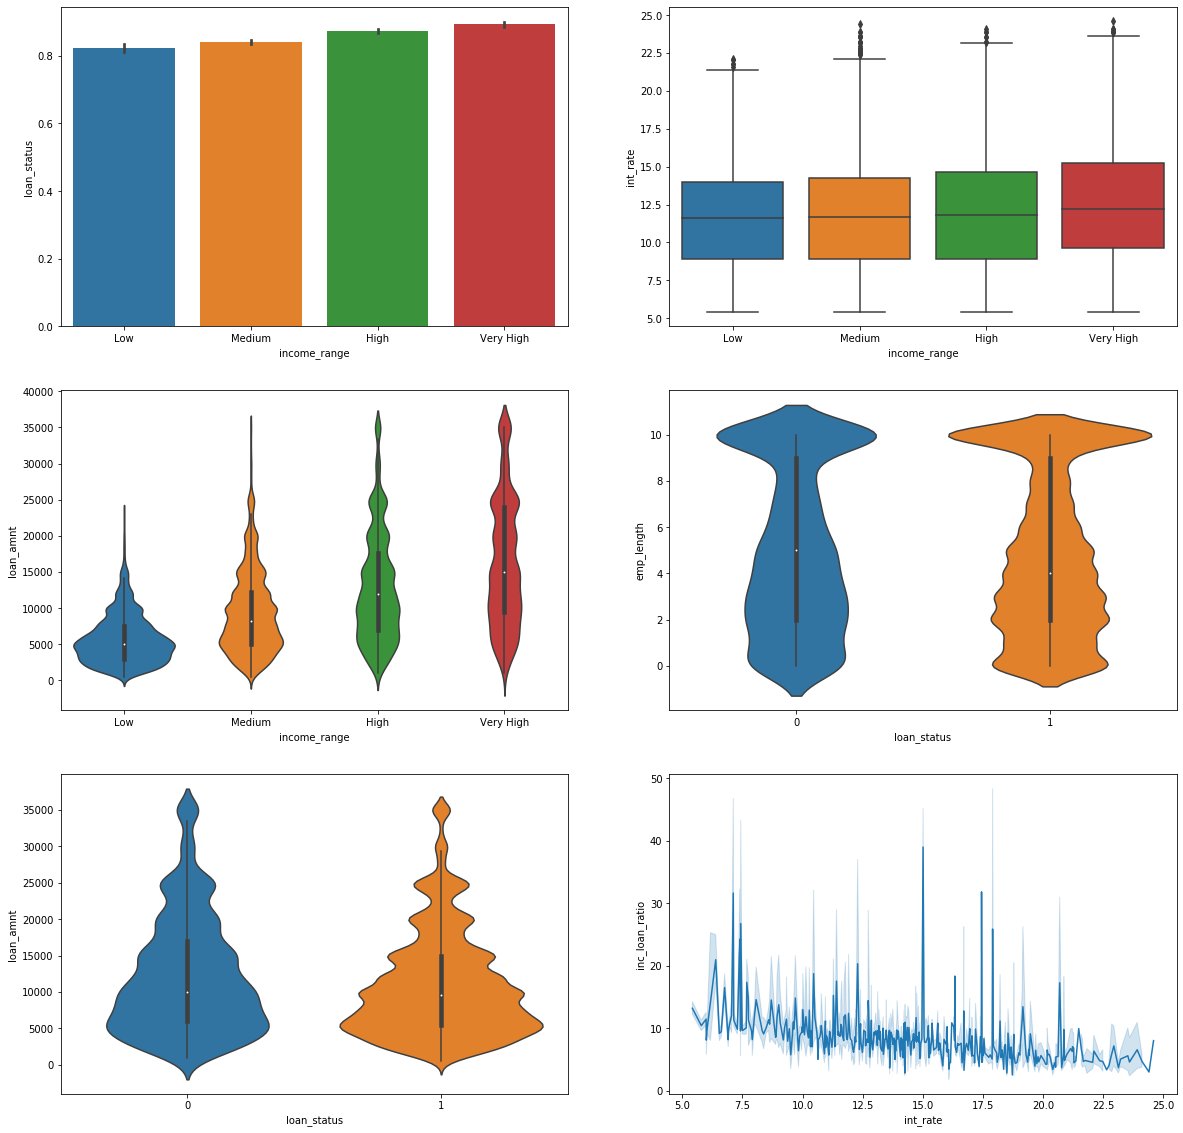

In [16]:
vis_df = df.copy()
#to update the income in 3 buckets
def inc_range(row):
    if row <= 30000:
        return "Low"
    elif (row >30000) and (row <= 60000):
        return "Medium"
    elif (row > 60000) and (row < 100000):
        return "High"
    else:
        return "Very High"
    
vis_df["income_range"] = vis_df["annual_inc"].apply(inc_range)
vis_df["inc_loan_ratio"] = vis_df["annual_inc"]/vis_df["loan_amnt"]
fig, ((ax1, ax2), (ax3, ax4),(ax5, ax6))= plt.subplots(nrows=3, ncols=2, figsize=(20,20))
sns.barplot(x="income_range", y="loan_status", data=vis_df,ax=ax1) #ax = ax1
sns.boxplot(x="income_range",y="int_rate",data=vis_df,ax=ax2)
sns.violinplot(x="income_range",y="loan_amnt",data=vis_df,ax=ax3)
sns.violinplot(x="loan_status",y="emp_length",data=vis_df,ax=ax4)
sns.violinplot(x="loan_status",y="loan_amnt",data=vis_df,ax=ax5)

sns.lineplot(x="int_rate",y="inc_loan_ratio",data=vis_df,ax=ax6)

What have we learned based on those plots?
1. People who has earned more are more likely to pay off the loans. This is very much expected. However, on average, we would've guessed that the difference might be bigger.
2. Pretty much the interest rate in general are the same across all borrowers. Higher income does not neccessarily require a higher interest. This is balanced by the fact that people of lower income tends to borrow less money in general (plot #3).
3. The amount of money borrowed varied, and has a higher spread as income level increases. This makes sense because one probably cannot borrow to buy a house with a very low income. It's just very unlikely.
4. There seems to be no difference on the decision of lending money based on employment length. However, it's interesting to note that people who has worked longer are less likely to apply for a loan(aside from the fact that we grouped everyone who has 10+ years of employment, thus exaggerating its meaning).
5. Plot #5 is just another way to look at plot #1 and plot #3, confirming the fact that most of the loan applications aren't high in values.
6. We took a income/loan ratio and see if it's correlated to the interest rate. Infact, it's quite clear (aside from occasional high points), that people who doesn't make much money and needed a big loan tend to have a higher interest rate. This is by far the best predictor in our loan approval technique.

# Let's utilize the raw data to see other trends in this dataset

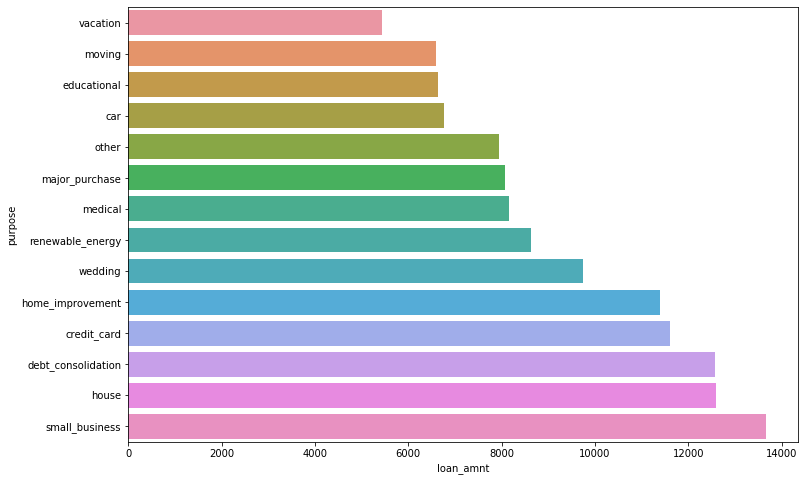

In [17]:
df_raw = pd.read_csv("loans_2007.csv")
#to group, take a mean of each column, and sort them for a prettier graph
temp = df_raw.groupby("purpose").mean().sort_values("loan_amnt").reset_index()
sns.barplot(x="loan_amnt",y="purpose",data=temp)

Finally, we import the older raw dataset to see our customer profile and the loan purposes. Which represented the consumer profile. Obviously, small businesses and bigger traps like credit card debts, wedding, and home improvement represented on average a higher **loan_amnt** per request. It's a good thing that based on our plot #5 above, the approval rate isn't neccessarily dictated by the loan amount. It is the utmost importance that the borrower can pay for it with a higher salary based on our plot #6. Else, we compensate for the risks with the higher interest rate.

In [18]:
#reprocessing for some of the raw data to look further into the analysis
df_raw["income_range"] = df_raw["annual_inc"].apply(inc_range)
df_raw['int_rate'] = df_raw['int_rate'].str.rstrip('%')
df_raw['int_rate'] = df_raw['int_rate'].astype('float')
df_raw["inc_loan_ratio"] = df_raw["annual_inc"]/df_raw["loan_amnt"]

print(df_raw.columns)

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'annual_inc', 'verification_status',
       'issue_d', 'loan_status', 'pymnt_plan', 'purpose', 'title', 'zip_code',
       'addr_state', 'dti', 'delinq_2yrs', 'earliest_cr_line',
       'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util',
       'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_d', 'last_pymnt_amnt', 'last_credit_pull_d',
       'collections_12_mths_ex_med', 'policy_code', 'application_type',
       'acc_now_delinq', 'chargeoff_within_12_mths', 'delinq_amnt',
       'pub_rec_bankruptcies', 'tax_liens', 'income_range', 'inc_loan_ratio'],
      dtype='object')


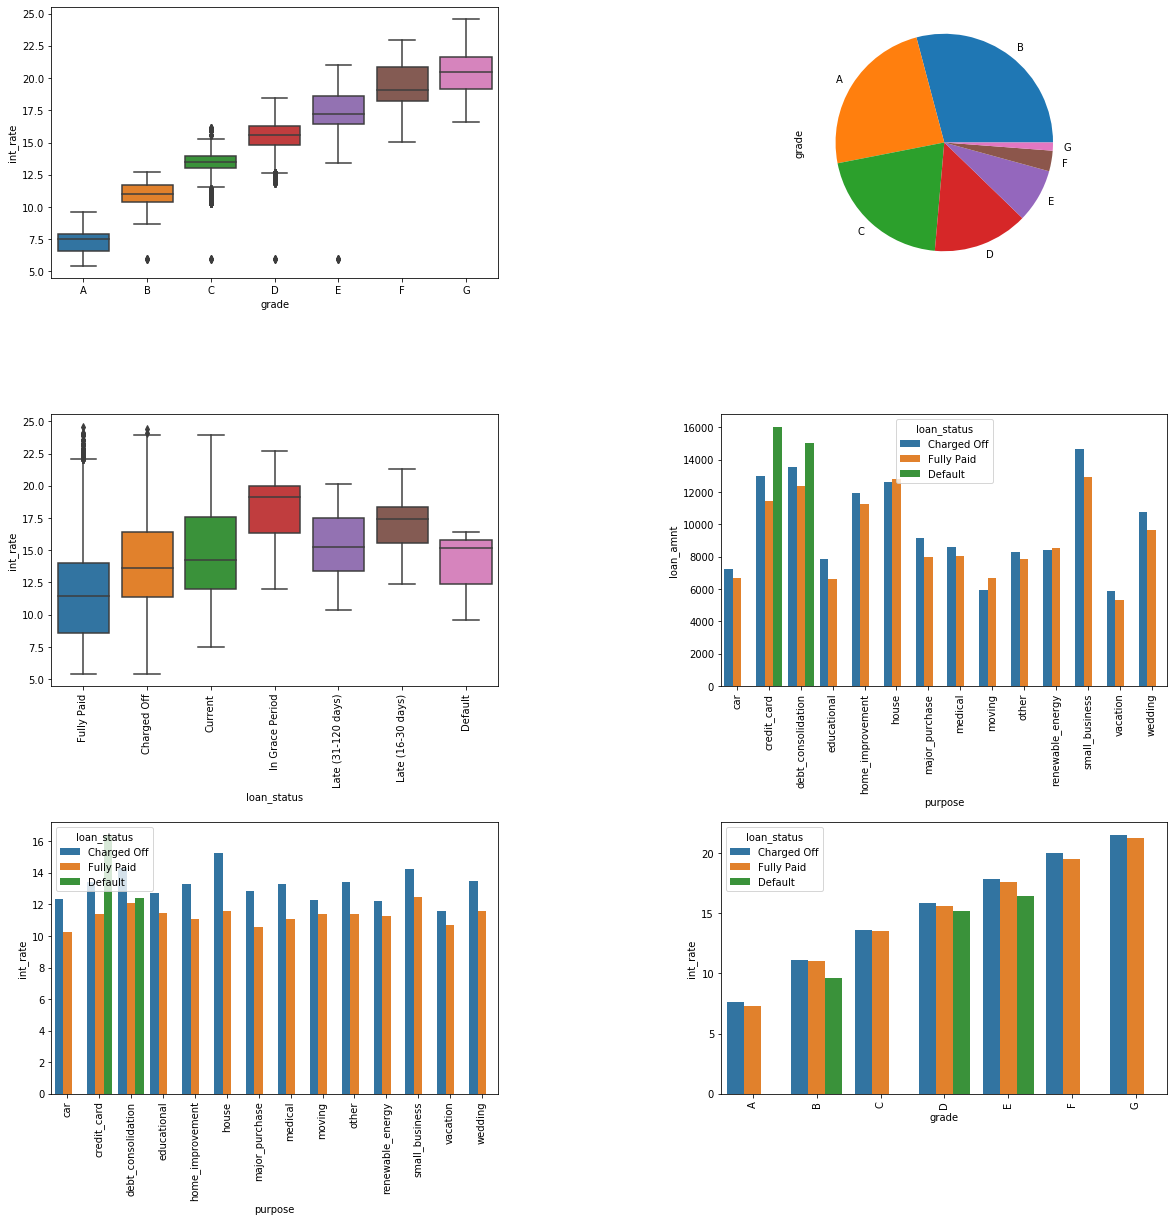

In [19]:
def plot3(df_raw):
    temp = df_raw[~df_raw['loan_status'].isin(["Does not meet the credit policy. Status:Fully Paid",
                                               "Does not meet the credit policy. Status:Charged Off"])]
    sns.boxplot(x="loan_status", y="int_rate", data=temp,ax=ax3) #charge off and default rate needs to be high
    ax3.set_xticklabels(ax3.get_xticklabels(),rotation=90)


#helper function with plot #4. Mean loan_amnt for various purposes
def plot4(df_raw):
    temp = df_raw.loc[df_raw['loan_status'].isin(['Charged Off','Default','Fully Paid'])]
    temp = temp.groupby(["purpose","loan_status"]).mean()
    temp.reset_index(inplace = True)
    sns.barplot(x="purpose",y="loan_amnt",hue="loan_status",data=temp,ax=ax4)
    ax4.set_xticklabels(ax4.get_xticklabels(),rotation=90)

#helper function with plot #5. Which loan purpose can generate most values without being the most risky
def plot5(df_raw):
    temp = df_raw.loc[df_raw['loan_status'].isin(['Charged Off','Default','Fully Paid'])]
    temp = temp.groupby(["purpose","loan_status"]).mean()
    temp.reset_index(inplace = True)
    sns.barplot(x="purpose",y="int_rate",hue="loan_status",data=temp,ax=ax5)
    ax5.set_xticklabels(ax5.get_xticklabels(),rotation=90)

#helper function with plot #6. Can we count on the fact that higher credits loans are safer in general?
#this is an essential question to recap our data
def plot6(df_raw):
    temp = df_raw.loc[df_raw['loan_status'].isin(['Charged Off','Default','Fully Paid'])]
    temp = temp.groupby(["grade","loan_status"]).mean()
    temp.reset_index(inplace = True)
    sns.barplot(x="grade",y="int_rate",hue="loan_status",data=temp,ax=ax6)
    ax6.set_xticklabels(ax6.get_xticklabels(),rotation=90)

fig, ((ax1, ax2), (ax3, ax4),(ax5, ax6))= plt.subplots(nrows=3, ncols=2, figsize=(20,20))
plt.subplots_adjust(hspace=0.5, wspace=0.5) #to adjust spacings between plots

#plot #1, interest rate vs. loan grade
sns.boxplot(x="grade", y="int_rate", data=df_raw,order=["A","B","C","D","E","F","G"],ax=ax1)
#plot #2, pie chart of loan grades.
df_raw["grade"].value_counts().plot(kind='pie', subplots=True, figsize=(8,8),ax=ax2)
plot3(df_raw)
plot4(df_raw)
plot5(df_raw)
plot6(df_raw)

It seems that there's no free lunch here from the above information.
1. Grades are based off from interest rate. It makes sense to remove them for our features
2. Most of our loans are reasonably safe, at the grades of A,B,C, and D.
3. On average, our loans with lower interest rate has a higher chance to be paid off. Perhaps, below 11% is a good bet.

4 & 5. No clear trend on which category of loan has the best paid-off/charge off ratio. We also had a couple of defaults in the credit card category (this is insignificant amount compared to fully paid and charge-off).

6 . Again, we see interest rate with grade assigned for each loan. However, it's interesting to note that there is no clear trend as to why high quality loans don't have a higher fully paid/charge-off ratio.

Lastly, we'll look at the ratio of income/loans and loan_status

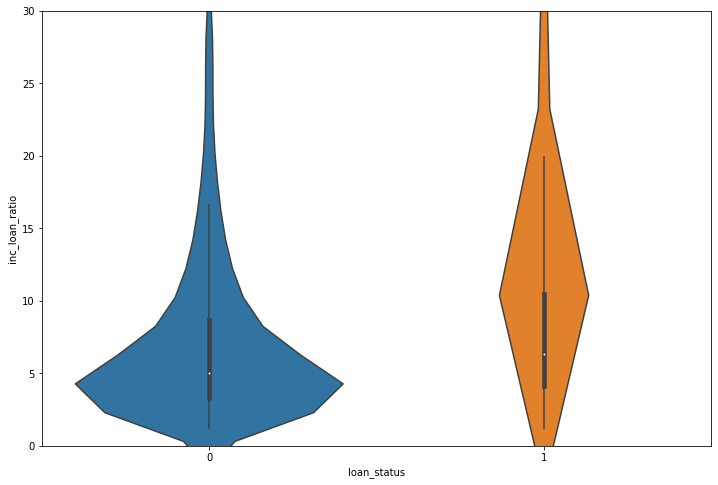

In [20]:
#print(vis_df.shape)
sns.violinplot(x="loan_status",y="inc_loan_ratio",data=vis_df)
plt.ylim(0,30)
plt.show()

Finally, the 10x and above - "income" to "loan amount" ratio certainly helps secure our full payments. At 10x the ratio, it's safe to say that there will be statistically more people who's going to pay off their loans. It doesn't guarantee if the bad loan amounts will be covered with the good loan amounts however.

# Machine Learning Algorithms - Part 1

For this problem, we'll divide it into 2 parts. For the first part, we'll worry ourselves with algorithms that does not need feature scaling, and for the second part, we'll use feature scaling algorithms.
Since we do have a non-balance classification, we need something other than accuracy. The standard convention would be using roc, auc. **However, due to the fact that it doesn't utilise all 4 quadrants of the confusion matrix during the test runs, we'll be sticking with another "balanced" metric, called Mathew Coefficient of correlation.**

precision = tp/(tp+fp)

recall = tp/(tp+fn)

MCC is known to be better than accuracy or F1 score in binary classification because it takes into account of 4 quadrants of our confusion matrix. We want to look at the overall improvement, not neccessarily leaving potential money by optimizing for either f1, recall or precision.

https://en.wikipedia.org/wiki/Matthews_correlation_coefficient#Advantages_of_MCC_over_accuracy_and_F1_score

In [21]:
#Let's see our target profile
df.loan_status.value_counts(normalize=True)

1    0.856961
0    0.143039
Name: loan_status, dtype: float64

In [22]:
#custom scorer
#we'll be using Matthew correlation coefficient, or MCC. 
#This was decided based on previous trials earlier with optimization on AUC ROC, and f1-score
scoring = {
    "accuracy":make_scorer(accuracy_score),
    "precision":make_scorer(precision_score),
    "recall":make_scorer(recall_score),
    "mcc":make_scorer(matthews_corrcoef)
}

In [23]:
#Spreadsheet of algorithms to filter initially (baseline models)
#https://machinelearningmastery.com/gentle-introduction-xgboost-applied-machine-learning/
#we need to account for imbalance classes whenever possible for all these algorithms by either oversampling or weight penalty.
#85:15 isn't too bad in which we can just use weight penalty for our problem
tree_algs = [tree.DecisionTreeClassifier(class_weight="balanced"), tree.ExtraTreeClassifier(class_weight="balanced"),
             XGBClassifier(scale_pos_weight=0.15)] #gradient boosted tree

ensemble_algs = [ensemble.AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(class_weight="balanced")), 
                ensemble.BaggingClassifier(base_estimator=tree.DecisionTreeClassifier(class_weight="balanced")), 
                ensemble.ExtraTreesClassifier(class_weight="balanced"),
                ensemble.GradientBoostingClassifier(), ensemble.RandomForestClassifier(class_weight="balanced")]
linear_algs = [linear_model.LogisticRegressionCV(class_weight="balanced")]
da_algs = [discriminant_analysis.LinearDiscriminantAnalysis(), discriminant_analysis.QuadraticDiscriminantAnalysis()]

In [24]:
df.columns

Index(['loan_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc',
       'loan_status', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'term_ 36 months',
       'term_ 60 months'],
      dtype='object')

In [25]:
features = df.columns.tolist()
features.remove("loan_status")

#we remove these columns because it is important to prevent biases/double counting due to dummy variables trap.
#this wasn't done in the preprocessing step because we wanted to use them with the data explorative analysis step.
features.remove("home_ownership_OTHER")
features.remove("verification_status_Source Verified")
features.remove("purpose_other")
features.remove("term_ 60 months")

target = "loan_status"
print(features)

def baseline_ml(algs,features,target,scoring,df):
    
    X_train, X_test, y_train, y_test = model_selection.train_test_split(df[features], df[target], test_size=0.25,stratify=df[target],
                                                                        random_state=1)
    #print(X_train.shape,X_test.shape,y_train.shape, y_test.shape)
    #making a dataframe spreadsheet of ML Algorithms performances
    ml_cols = ["ML_alg","ML_params","ML_runtime","ML_train_accuracy","ML_train_precision","ML_train_recall","ML_train_mcc",
               "ML_test_accuracy","ML_test_precision","ML_test_recall","ML_test_mcc"]
    ml_table = pd.DataFrame(columns=ml_cols)

    #ml_pred = y_test

    row_ind = 0
    for alg in algs:

        cv_results = model_selection.cross_validate(alg, X_train, y_train, scoring=scoring, cv=10,
                                                   return_train_score=True) #main object
        #print(cv_results)
        #fill in the table by calling attributes from the cv_results object
        alg_name = alg.__class__.__name__
        ml_table.loc[row_ind, 'ML_alg'] = alg_name
        ml_table.loc[row_ind, 'ML_params'] = str(alg.get_params())
        ml_table.loc[row_ind, 'ML_runtime'] = cv_results['fit_time'].mean()
        ml_table.loc[row_ind, 'ML_train_accuracy'] = cv_results['train_accuracy'].mean()
        ml_table.loc[row_ind, 'ML_train_precision'] = cv_results['train_precision'].mean()
        ml_table.loc[row_ind, 'ML_train_recall'] = cv_results['train_recall'].mean() 
        ml_table.loc[row_ind, 'ML_train_mcc'] = cv_results['train_mcc'].mean()

        ml_table.loc[row_ind, 'ML_test_accuracy'] = cv_results['test_accuracy'].mean()
        ml_table.loc[row_ind, 'ML_test_precision'] = cv_results['test_precision'].mean()
        ml_table.loc[row_ind, 'ML_test_recall'] = cv_results['test_recall'].mean() 
        ml_table.loc[row_ind, 'ML_test_mcc'] = cv_results['test_mcc'].mean()

        alg.fit(X_train, y_train)
        #prediction needs to be returned later for a second stage ensemble
        ml_pred = alg.predict(X_test)
        #print(cv_results.keys())

        row_ind += 1
    return ml_table, ml_pred

['loan_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Not Verified', 'verification_status_Verified', 'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding', 'term_ 36 months']


In [27]:
#Spreadsheet of algorithms to filter initially, all baseline models with weighted class balance.
tree_table,temp = baseline_ml(tree_algs,features,target,scoring,df)
tree_table

,ML_alg,ML_params,ML_runtime,ML_train_accuracy,ML_train_precision,ML_train_recall,ML_train_mcc,ML_test_accuracy,ML_test_precision,ML_test_recall,ML_test_mcc
0,DecisionTreeClassifier,"{'class_weight': 'balanced', 'criterion': 'gin...",0.303371,1,1,1,1,0.769785,0.868273,0.862147,0.0774012
1,ExtraTreeClassifier,"{'class_weight': 'balanced', 'criterion': 'gin...",0.0424649,1,1,1,1,0.770102,0.865749,0.866028,0.0614466
2,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",4.99262,0.628708,0.933168,0.61045,0.245877,0.614383,0.920498,0.602008,0.20498


In [28]:
ensemble_table,temp = baseline_ml(ensemble_algs,features,target,scoring,df)
ensemble_table

,ML_alg,ML_params,ML_runtime,ML_train_accuracy,ML_train_precision,ML_train_recall,ML_train_mcc,ML_test_accuracy,ML_test_precision,ML_test_recall,ML_test_mcc
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator__clas...",0.311786,1,1,1,1,0.767908,0.867431,0.860701,0.071464
1,BaggingClassifier,"{'base_estimator__class_weight': 'balanced', '...",2.01031,0.992104,0.991756,0.999091,0.967524,0.836742,0.863561,0.961386,0.086091
2,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': 'balanced...",0.357542,1,1,1,1,0.839645,0.862606,0.966879,0.0800601
3,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",3.22957,0.860403,0.860942,0.998353,0.143422,0.857304,0.859265,0.996737,0.0851379
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': 'balanced'...",0.382144,0.99256,0.991966,0.999413,0.969421,0.845696,0.862219,0.975882,0.085991


In [29]:
#oh wow! one of the highest mcc thus far with just Logistic Reg. Even better than the ensemble techniques with these baselines
linear_table,temp = baseline_ml(linear_algs,features,target,scoring,df)
linear_table

,ML_alg,ML_params,ML_runtime,ML_train_accuracy,ML_train_precision,ML_train_recall,ML_train_mcc,ML_test_accuracy,ML_test_precision,ML_test_recall,ML_test_mcc
0,LogisticRegressionCV,"{'Cs': 10, 'class_weight': 'balanced', 'cv': '...",1.03885,0.565658,0.907137,0.549411,0.148855,0.564728,0.905215,0.549599,0.143797


In [30]:
da_table,temp = baseline_ml(da_algs,features,target,scoring,df)
da_table

,ML_alg,ML_params,ML_runtime,ML_train_accuracy,ML_train_precision,ML_train_recall,ML_train_mcc,ML_test_accuracy,ML_test_precision,ML_test_recall,ML_test_mcc
0,LinearDiscriminantAnalysis,"{'n_components': None, 'priors': None, 'shrink...",0.160682,0.855983,0.860192,0.993401,0.0905708,0.85557,0.86002,0.993103,0.0868031
1,QuadraticDiscriminantAnalysis,"{'priors': None, 'reg_param': 0.0, 'store_cova...",0.0663125,0.144622,0.850415,0.00221635,-0.00070316,0.144571,0.863442,0.00227136,-0.00209439


In [31]:
#stratify to preserve the ratio of imbalanced data
X_train, X_test, y_train, y_test = model_selection.train_test_split(df[features], df[target], test_size=0.25,stratify=df[target],
                                                                    random_state=1)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

1    0.856951
0    0.143049
Name: loan_status, dtype: float64
1    0.856991
0    0.143009
Name: loan_status, dtype: float64


In [34]:
#so our baseline prediction is (let's assume everything is 1 for our loan target), no learning involved
acc_baseline = 0.85 #a very meaningless stats here
prec_baseline = 0.85/(0.85+0.15)
rec_baseline = 0.85/(0.85+0) #we never predict 0 for false negative

print("accuracy baseline: ",acc_baseline, "\nprecision baseline: ", prec_baseline, "\nrecall_baseline: ",rec_baseline)
print("Keep in mind that the recall baseline is meaningless here since we don't predict 0 at all.\nHowever, we can see that it's very high toward 1")

accuracy baseline:  0.85 
precision baseline:  0.85 
recall_baseline:  1.0
Keep in mind that the recall baseline is meaningless here since we don't predict 0 at all.
However, we can see that it's very high toward 1


Therefore, let's use a different benchmark to tune in our data, Mathew Correlation Coefficient.<br>
**A -1 means we classified everything wrong.<br> A 1 means we classified everything right**
**MCC is a balanced metric, so our imbalanced dataset is good enough.**

# Algorithms Focus #1:

What we've learned?
Our tree models are overfitting, which is expected in the default state (this is also seen with perfect/near perfect score on the training set).
The overfitting continues with ensemble algorithms.
Logistic regression seems to be competitive enough surprisingly.
Due to the limitation toward imbalance dataset on the current baseline, LDA and QDA probably are not a good idea to be used.

Let's keep:
XGBClassifier, all of the ensemble techniques, and Logistic Regression.

In [35]:
#let's put them all in a table. Baseline
algs_set1 = [tree.DecisionTreeClassifier(class_weight="balanced"), tree.ExtraTreeClassifier(class_weight="balanced"),
             XGBClassifier(scale_pos_weight=0.15),ensemble.AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(class_weight="balanced")), 
             ensemble.BaggingClassifier(base_estimator=tree.DecisionTreeClassifier(class_weight="balanced")), 
             ensemble.ExtraTreesClassifier(class_weight="balanced"), ensemble.GradientBoostingClassifier(), 
             ensemble.RandomForestClassifier(class_weight="balanced"),linear_model.LogisticRegressionCV(class_weight="balanced")] 
table_set1,temp = baseline_ml(algs_set1,features,target,scoring,df)
table_set1

,ML_alg,ML_params,ML_runtime,ML_train_accuracy,ML_train_precision,ML_train_recall,ML_train_mcc,ML_test_accuracy,ML_test_precision,ML_test_recall,ML_test_mcc
0,DecisionTreeClassifier,"{'class_weight': 'balanced', 'criterion': 'gin...",0.310636,1,1,1,1,0.770881,0.868357,0.863551,0.0783034
1,ExtraTreeClassifier,"{'class_weight': 'balanced', 'criterion': 'gin...",0.0426329,1,1,1,1,0.767659,0.865661,0.862764,0.0602101
2,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",5.05337,0.628708,0.933168,0.61045,0.245877,0.614383,0.920498,0.602008,0.20498
3,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator__clas...",0.305325,1,1,1,1,0.768157,0.867588,0.860825,0.0726626
4,BaggingClassifier,"{'base_estimator__class_weight': 'balanced', '...",1.84337,0.992379,0.992171,0.99899,0.968664,0.840175,0.864188,0.965185,0.0975525
5,ExtraTreesClassifier,"{'bootstrap': False, 'class_weight': 'balanced...",0.30731,1,1,1,1,0.839893,0.862509,0.967374,0.0790746
6,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",3.15027,0.860403,0.860942,0.998353,0.143422,0.85734,0.85927,0.996779,0.0855879
7,RandomForestClassifier,"{'bootstrap': True, 'class_weight': 'balanced'...",0.391793,0.992643,0.991927,0.99955,0.969768,0.844635,0.862525,0.97394,0.0862616
8,LogisticRegressionCV,"{'Cs': 10, 'class_weight': 'balanced', 'cv': '...",1.02748,0.565658,0.907137,0.549411,0.148855,0.564728,0.905215,0.549599,0.143797


In [36]:
#refer to:https://lettier.github.io/posts/2016-08-05-matthews-correlation-coefficient.html
#we can also try the "balanced_accuracy" scorer, which is also designed for imbalanced dataset.
#It takes into account of the average macro recall. Let's stick with the former.

mcc_scorer = make_scorer(matthews_corrcoef)
#helper function for hyperparameter tuning
def tuning_grid(model_,features,target,hyperparams,df):
    global mcc_scorer
    X_train, X_test, y_train, y_test = model_selection.train_test_split(df[features], df[target], test_size=0.25, stratify=df[target],
                                                                        random_state=1)
    model = model_selection.GridSearchCV(model_,param_grid=hyperparams,scoring=mcc_scorer, cv = 10)
    model.fit(X_train,y_train)
    print(model.best_params_)
    print(model.cv_results_['mean_train_score'])
    print(model.cv_results_['mean_test_score'])
    return model

In [37]:
#fine-tunning hyperparameters with GridsearchCV
#Store the estimators in this dictionary for later usage
hyper_tuning = {}
Y_pred = pd.DataFrame()

In [38]:
XGBClassifier_hp = {"eta":[0.1,0.2], #learning rate
                    "min_child_weight":[1], #“sum of weights” of observations while GBM has min “number of observations”.
                    #used lower number because of class imbalance
                    "max_depth":[3,6,9,13], #pruning to control overfitting
                    "scale_pos_weight":[0.17,0.1] #the ratio of positive to negative (0.15/0.85), imbalanced dataset
                   }

#manually optimize for window, testing
#tune_model = model_selection.GridSearchCV(XGBClassifier(),param_grid=XGBClassifier_hp,scoring="matthews_corrcoef", cv = 2)
#fit to tune the gridsearch
#tune_model.fit(X_test,y_test)

#print(tune_model.cv_results_.keys())
#print(tune_model.cv_results_['params'])
#print(tune_model.best_params_)

In [39]:
'''
XGB_model = tuning_grid(XGBClassifier(),features,target,XGBClassifier_hp,df)
XGB_model
'''

'\nXGB_model = tuning_grid(XGBClassifier(),features,target,XGBClassifier_hp,df)\nXGB_model\n'

In [40]:
#best model we have for XGBClassifier post-tuning
#we did improve the mcc value quite a bit here from the default. 
#at the expense of higher precision, we have been lowering our recall rate.
current_model = [XGBClassifier(eta=0.1, max_depth=3, min_child_weight=1,scale_pos_weight=0.17,random_state=1)]
current_table,y_pred = baseline_ml(current_model,features,target,scoring,df)

hyper_tuning["XGBClassifier"] = current_model
Y_pred["XGBClassifier"] = y_pred
current_table

,ML_alg,ML_params,ML_runtime,ML_train_accuracy,ML_train_precision,ML_train_recall,ML_train_mcc,ML_test_accuracy,ML_test_precision,ML_test_recall,ML_test_mcc
0,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",5.10489,0.676022,0.925781,0.676147,0.254279,0.662266,0.914041,0.668787,0.211451


In [41]:
#AdaBoostClassfier, max_depth has to be minimum of 3 to perform better than random guesses(error).
#we want weak learners so we use max_depth=3 for each learner.
'''
AdaBoostClassifier_hp = {"base_estimator":[tree.DecisionTreeClassifier(class_weight='balanced',max_depth=3)],
                         "n_estimators":[100,250,400,550],"learning_rate":[0.3,0.6,1,1.5],
                         "algorithm":["SAMME","SAMME.R"],"random_state":[1]}
AdaBoostClassifier_model = tuning_grid(ensemble.AdaBoostClassifier(),features,target,AdaBoostClassifier_hp,df)
AdaBoostClassifier_model
'''

'\nAdaBoostClassifier_hp = {"base_estimator":[tree.DecisionTreeClassifier(class_weight=\'balanced\',max_depth=3)],\n                         "n_estimators":[100,250,400,550],"learning_rate":[0.3,0.6,1,1.5],\n                         "algorithm":["SAMME","SAMME.R"],"random_state":[1]}\nAdaBoostClassifier_model = tuning_grid(ensemble.AdaBoostClassifier(),features,target,AdaBoostClassifier_hp,df)\nAdaBoostClassifier_model\n'

In [42]:
#best AdaBoostClassifier post-tuning
#the learning rate and n_estimators are inversely related (somewhat) due to the effectiveness of each weak leaner.
#using balanced decisiontree for class imbalance, keep default hyperparam
current_model = [ensemble.AdaBoostClassifier(base_estimator=tree.DecisionTreeClassifier(class_weight='balanced',max_depth=3),
                                             n_estimators=100,learning_rate=0.3,algorithm="SAMME.R",random_state=1)]
current_table, y_pred = baseline_ml(current_model,features,target,scoring,df)
hyper_tuning["AdaBoostClassifier"] = current_model
Y_pred["AdaBoostClassifier"] = y_pred
current_table

,ML_alg,ML_params,ML_runtime,ML_train_accuracy,ML_train_precision,ML_train_recall,ML_train_mcc,ML_test_accuracy,ML_test_precision,ML_test_recall,ML_test_mcc
0,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator__clas...",6.45408,0.698919,0.94062,0.692373,0.312344,0.662407,0.911032,0.671636,0.202416


In [43]:
#max_samples hyperparameter is for the number of observations being used - percentage/ratio of total sample size.
#max_features hyperparameter is for the number of features being used - percentage/ratio of total features.
#same weak learner as the previous AdaBoost for the base_estimator.
'''
BaggingClassifier_hp = {"base_estimator":[tree.DecisionTreeClassifier(class_weight='balanced',max_depth=3)],
                        "n_estimators":[10,30,50,70,90],"max_samples":[0.7,1],"max_features":[0.5,0.7,1],"random_state":[1]}
BaggingClassifier_model = tuning_grid(ensemble.BaggingClassifier(),features,target,BaggingClassifier_hp,df)
BaggingClassifier_model
'''

'\nBaggingClassifier_hp = {"base_estimator":[tree.DecisionTreeClassifier(class_weight=\'balanced\',max_depth=3)],\n                        "n_estimators":[10,30,50,70,90],"max_samples":[0.7,1],"max_features":[0.5,0.7,1],"random_state":[1]}\nBaggingClassifier_model = tuning_grid(ensemble.BaggingClassifier(),features,target,BaggingClassifier_hp,df)\nBaggingClassifier_model\n'

In [44]:
#best BaggingClassifier model post-tuning
#the learning rate and n_estimators are inversely related (somewhat) due to the effectiveness of each weak leaner.
#perhaps one of the better mcc value thus far.
current_model = [ensemble.BaggingClassifier(base_estimator=tree.DecisionTreeClassifier(class_weight='balanced',max_depth=3),
                                            n_estimators=90,max_samples=0.7,max_features=0.5,random_state=1)] 
current_table, y_pred = baseline_ml(current_model,features,target,scoring,df)
Y_pred["BaggingClassifier"] = y_pred
hyper_tuning["BaggingClassifier"] = current_model
current_table

,ML_alg,ML_params,ML_runtime,ML_train_accuracy,ML_train_precision,ML_train_recall,ML_train_mcc,ML_test_accuracy,ML_test_precision,ML_test_recall,ML_test_mcc
0,BaggingClassifier,"{'base_estimator__class_weight': 'balanced', '...",2.01467,0.645421,0.915977,0.645453,0.208125,0.642482,0.912553,0.644545,0.196908


In [45]:
#balanced weight = 0.85/0.15 = 0.56
'''
ExtraTreeClassifier_hp = {"class_weight":["balanced",{0:1,1:1},{0:7,1:1},{0:10,1:1}],"criterion":["gini","entropy"],
                          "max_depth":[5,10,15],"min_samples_leaf":[3,6,9,12],"random_state":[1]}
ExtraTreeClassifier_model = tuning_grid(tree.ExtraTreeClassifier(),features,target,ExtraTreeClassifier_hp,df)
ExtraTreeClassifier_model
'''

'\nExtraTreeClassifier_hp = {"class_weight":["balanced",{0:1,1:1},{0:7,1:1},{0:10,1:1}],"criterion":["gini","entropy"],\n                          "max_depth":[5,10,15],"min_samples_leaf":[3,6,9,12],"random_state":[1]}\nExtraTreeClassifier_model = tuning_grid(tree.ExtraTreeClassifier(),features,target,ExtraTreeClassifier_hp,df)\nExtraTreeClassifier_model\n'

In [46]:
#best ExtraTreeClassifier model post-tuning
current_model = [tree.ExtraTreeClassifier(criterion="entropy", class_weight="balanced",max_depth=5, min_samples_leaf=6,random_state=1)]
current_table, y_pred = baseline_ml(current_model,features,target,scoring,df)
hyper_tuning["ExtraTreeClassifier"] = current_model
Y_pred["ExtraTreeClassifier"] = y_pred
current_table
#quite a good result with the fast runtime

,ML_alg,ML_params,ML_runtime,ML_train_accuracy,ML_train_precision,ML_train_recall,ML_train_mcc,ML_test_accuracy,ML_test_precision,ML_test_recall,ML_test_mcc
0,ExtraTreeClassifier,"{'class_weight': 'balanced', 'criterion': 'ent...",0.022518,0.594643,0.89315,0.598621,0.12326,0.591446,0.89081,0.596433,0.115013


In [47]:
#refer to: https://www.analyticsvidhya.com/blog/2016/02/complete-guide-parameter-tuning-gradient-boosting-gbm-python/
#for hyperparameter tuning, it's unlikely to beat XGBClassifier previously
#let's do a rough estimate
'''
GBClassifier_hp = {"learning_rate":[0.05,0.1,0.15],"n_estimators":[40,60,80,100],
                   "max_features":["auto","sqrt","log2"],"max_depth":[3,6,8],"random_state":[1]}
GradientBoostingClassifier_model = tuning_grid(ensemble.GradientBoostingClassifier(),features,target,GBClassifier_hp,df)
GradientBoostingClassifier_model
'''

'\nGBClassifier_hp = {"learning_rate":[0.05,0.1,0.15],"n_estimators":[40,60,80,100],\n                   "max_features":["auto","sqrt","log2"],"max_depth":[3,6,8],"random_state":[1]}\nGradientBoostingClassifier_model = tuning_grid(ensemble.GradientBoostingClassifier(),features,target,GBClassifier_hp,df)\nGradientBoostingClassifier_model\n'

In [48]:
#best GB model post-tuning
current_model = [ensemble.GradientBoostingClassifier(learning_rate=0.15, n_estimators=100, min_samples_split=0.005,
                                                    max_features="sqrt",max_depth=8, random_state=1)]
current_table, y_pred = baseline_ml(current_model,features,target,scoring,df)
#hyper_tuning["GradientBoostingClassifier"] = current_model
#Y_pred["GradientBoostingClassifier"] = y_pred
current_table
#long runtime and very unsatisfied result, not much better than baselines, and worse than the XGB algorithm. 
#The problem comes from the unavailablity to treat imbalance datasets. We'll skip this model.

,ML_alg,ML_params,ML_runtime,ML_train_accuracy,ML_train_precision,ML_train_recall,ML_train_mcc,ML_test_accuracy,ML_test_precision,ML_test_recall,ML_test_mcc
0,GradientBoostingClassifier,"{'criterion': 'friedman_mse', 'init': None, 'l...",2.80695,0.886203,0.88358,0.998812,0.423118,0.853482,0.861853,0.98728,0.101666


In [49]:
'''
RandomForestClassifier_hp = {"class_weight":["balanced"],"min_samples_split":[0.005],
                             "max_depth":[3,5,7,9,11],"n_estimators":[10,20,30,40]}
RF_model = tuning_grid(ensemble.RandomForestClassifier(),features,target,RandomForestClassifier_hp,df)
RF_model
'''

'\nRandomForestClassifier_hp = {"class_weight":["balanced"],"min_samples_split":[0.005],\n                             "max_depth":[3,5,7,9,11],"n_estimators":[10,20,30,40]}\nRF_model = tuning_grid(ensemble.RandomForestClassifier(),features,target,RandomForestClassifier_hp,df)\nRF_model\n'

In [50]:
#Best RF model post-tuning
current_model = [ensemble.RandomForestClassifier(n_estimators=40, class_weight="balanced", max_depth=9, min_samples_split=0.005,random_state=1)]
current_table,y_pred = baseline_ml(current_model,features,target,scoring,df)
Y_pred["RandomForestClassifier"] = y_pred
hyper_tuning["RandomForestClassifier"] = current_model
current_table
#pred.head()

,ML_alg,ML_params,ML_runtime,ML_train_accuracy,ML_train_precision,ML_train_recall,ML_train_mcc,ML_test_accuracy,ML_test_precision,ML_test_recall,ML_test_mcc
0,RandomForestClassifier,"{'bootstrap': True, 'class_weight': 'balanced'...",0.866164,0.702022,0.929546,0.705781,0.282992,0.677414,0.909806,0.692163,0.206839


In [51]:
#Each of the values in Cs describes the inverse of regularization strength. 
#If Cs is as an int, then a grid of Cs values are chosen in a logarithmic scale between 1e-4 and 1e4. 
#Like in svm, smaller values specify stronger regularization.
'''
LogisticRegression_hp = {"penalty":["l2"],"class_weight":["balanced"],"max_iter":[1000],"n_jobs":[-1],
                        "Cs":[i for i in range(1,100,3)],"random_state":[1]}
LogisticRegression_model = tuning_grid(linear_model.LogisticRegressionCV(),features,target,LogisticRegression_hp,df)
LogisticRegression_model
'''

'\nLogisticRegression_hp = {"penalty":["l2"],"class_weight":["balanced"],"max_iter":[1000],"n_jobs":[-1],\n                        "Cs":[i for i in range(1,100,3)],"random_state":[1]}\nLogisticRegression_model = tuning_grid(linear_model.LogisticRegressionCV(),features,target,LogisticRegression_hp,df)\nLogisticRegression_model\n'

In [52]:
#Best LR model post-tuning
current_model = [linear_model.LogisticRegressionCV(penalty="l2",class_weight="balanced",max_iter=1000, n_jobs=-1,Cs=97,
                                            random_state=1)]
current_table, y_pred = baseline_ml(current_model,features,target,scoring,df)
Y_pred["LogisticRegressionCV"] = y_pred
hyper_tuning["LogisticRegressionCV"] = current_model
current_table

,ML_alg,ML_params,ML_runtime,ML_train_accuracy,ML_train_precision,ML_train_recall,ML_train_mcc,ML_test_accuracy,ML_test_precision,ML_test_recall,ML_test_mcc
0,LogisticRegressionCV,"{'Cs': 97, 'class_weight': 'balanced', 'cv': '...",3.19327,0.568646,0.910906,0.55049,0.159711,0.567773,0.909753,0.550219,0.156454


In [53]:
#to put everything onto a table for summary
alg_set1 = list()
for key,val in hyper_tuning.items():
    alg_set1.append(val[0]) #the value itself is in a list too
#alg_set1
algset1_table, temp = baseline_ml(alg_set1,features,target,scoring,df)
algset1_table

,ML_alg,ML_params,ML_runtime,ML_train_accuracy,ML_train_precision,ML_train_recall,ML_train_mcc,ML_test_accuracy,ML_test_precision,ML_test_recall,ML_test_mcc
0,XGBClassifier,"{'base_score': 0.5, 'booster': 'gbtree', 'cols...",5.00115,0.676022,0.925781,0.676147,0.254279,0.662266,0.914041,0.668787,0.211451
1,AdaBoostClassifier,"{'algorithm': 'SAMME.R', 'base_estimator__clas...",6.66856,0.698919,0.94062,0.692373,0.312344,0.662407,0.911032,0.671636,0.202416
2,BaggingClassifier,"{'base_estimator__class_weight': 'balanced', '...",2.03619,0.645421,0.915977,0.645453,0.208125,0.642482,0.912553,0.644545,0.196908
3,ExtraTreeClassifier,"{'class_weight': 'balanced', 'criterion': 'ent...",0.0213255,0.594643,0.89315,0.598621,0.12326,0.591446,0.89081,0.596433,0.115013
4,RandomForestClassifier,"{'bootstrap': True, 'class_weight': 'balanced'...",0.811362,0.702022,0.929546,0.705781,0.282992,0.677414,0.909806,0.692163,0.206839
5,LogisticRegressionCV,"{'Cs': 97, 'class_weight': 'balanced', 'cv': '...",2.6324,0.568646,0.910906,0.55049,0.159711,0.567773,0.909753,0.550219,0.156454


In [56]:
#Y_pred.tail()
#let's do majority voting to benchmark our first round of algorithms
#recall we already splitted the train/test dataset previously.
#This is another ensemble on top of the current system. We can also use some algorithm to take these outputs for
#predictions, stacking. However, let's stick with the current idea of majority voting.

Y_pred["Vote1"] = Y_pred.mode(axis=1)[0] #need the zero for unpacking
Y_pred

print("accuracy: ", accuracy_score(y_test,Y_pred["Vote1"]))
print("Precision: ", precision_score(y_test,Y_pred["Vote1"]))
print("Recall: ",recall_score(y_test,Y_pred["Vote1"]))
print("MCC: ",matthews_corrcoef(y_test,Y_pred["Vote1"]))


accuracy:  0.6441235799978766
Precision:  0.9194809811589051
Recall:  0.6408572844400396
MCC:  0.21739419944434415


# Summary of the Part 1 of our algorithms

As seen, accuracy are not what we wanted. If the bank would like to be a conservative investor, it is better to have a very high precision with some expenses of recall (missing out the some right calls for more higher probability of getting the predictions right. Our majority voting technique (2nd stage ensemble) also helps get the better answer than any of the single models. Lastly, it is important to note that the MCC value maximizes the 4 quadrants of the confusion matrix, and maximizing it is probably the best way to do it, thus balancing both high precision with sufficient recall. Else we would be missing out of most of the investment opportunities with a high success rate.

# Machine Learning Algorithms focus #2

In [57]:
df.columns

Index(['loan_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc',
       'loan_status', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc',
       'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'home_ownership_MORTGAGE', 'home_ownership_NONE',
       'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT',
       'verification_status_Not Verified',
       'verification_status_Source Verified', 'verification_status_Verified',
       'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation',
       'purpose_educational', 'purpose_home_improvement', 'purpose_house',
       'purpose_major_purchase', 'purpose_medical', 'purpose_moving',
       'purpose_other', 'purpose_renewable_energy', 'purpose_small_business',
       'purpose_vacation', 'purpose_wedding', 'term_ 36 months',
       'term_ 60 months'],
      dtype='object')

In [58]:
#we'll categorize the continous variables together first prior to standardize the continous data
def sort_feats(df):
    cont_col_list = list()
    bin_col_list = list()
    features = df.columns.tolist()
    
    for col in features:
        if df[col].value_counts().shape[0] > 2:
            cont_col_list.append(col)
        else:
            bin_col_list.append(col)
    return cont_col_list, bin_col_list
        
cont_col_list, bin_col_list = sort_feats(df)

In [60]:
print(bin_col_list, cont_col_list)
#it seems that there's no mistake made in the bin_col_list. All of these are just dummy variables that we'd created earlier

['loan_status', 'home_ownership_MORTGAGE', 'home_ownership_NONE', 'home_ownership_OTHER', 'home_ownership_OWN', 'home_ownership_RENT', 'verification_status_Not Verified', 'verification_status_Source Verified', 'verification_status_Verified', 'purpose_car', 'purpose_credit_card', 'purpose_debt_consolidation', 'purpose_educational', 'purpose_home_improvement', 'purpose_house', 'purpose_major_purchase', 'purpose_medical', 'purpose_moving', 'purpose_other', 'purpose_renewable_energy', 'purpose_small_business', 'purpose_vacation', 'purpose_wedding', 'term_ 36 months', 'term_ 60 months'] ['loan_amnt', 'int_rate', 'installment', 'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc']


In [96]:
#we need to minmax scaling/Robust scaling between -1 to 1. After that, we would have to standardize our data
#finallly, we need to have the binary values feature in -1 and 1.

In [65]:
minmax_scaler = MinMaxScaler(feature_range=(-1,1))
std_scaler = StandardScaler(with_mean=True,with_std=True) #ensure mean of 0 and std of 1

cont_new = std_scaler.fit_transform(df[cont_col_list])
#cont_new = minmax_scaler.fit_transform(cont_new)
cont_new = std_scaler.fit_transform(cont_new)
cont_new = pd.DataFrame(columns=cont_col_list,data=cont_new)
#values aren't bound between -1 and 1 because many features aren't normally distributed. 
#Either we choose minmax/standard norm.

#binary set[-1,1]. #Can't normalize it but it will help offset the mean (reducing intercept)
bin_new = df[bin_col_list].replace(0,-1)
bin_new
df_new = pd.concat([cont_new,bin_new],axis=1)
#standard scaler = mean of 0 and std of 1
df_new.std()

loan_amnt                              1.000013
int_rate                               1.000013
installment                            1.000013
emp_length                             1.000013
annual_inc                             1.000013
dti                                    1.000013
delinq_2yrs                            1.000013
inq_last_6mths                         1.000013
open_acc                               1.000013
pub_rec                                1.000013
revol_bal                              1.000013
revol_util                             1.000013
total_acc                              1.000013
loan_status                            0.700235
home_ownership_MORTGAGE                0.993469
home_ownership_NONE                    0.017846
home_ownership_OTHER                   0.100830
home_ownership_OWN                     0.522688
home_ownership_RENT                    0.999271
verification_status_Not Verified       0.990761
verification_status_Source Verified    0

In [66]:
#df_new.head()
df_new.mean()

loan_amnt                              6.505396e-15
int_rate                               2.769590e-17
installment                            7.331156e-17
emp_length                            -4.574726e-15
annual_inc                            -3.941284e-16
dti                                   -7.352542e-16
delinq_2yrs                           -3.932019e-15
inq_last_6mths                         8.915443e-15
open_acc                               9.185515e-16
pub_rec                               -3.223792e-15
revol_bal                              8.882963e-17
revol_util                            -6.077488e-16
total_acc                              3.836789e-17
loan_status                            7.139217e-01
home_ownership_MORTGAGE               -1.142137e-01
home_ownership_NONE                   -9.998407e-01
home_ownership_OTHER                  -9.949038e-01
home_ownership_OWN                    -8.525282e-01
home_ownership_RENT                   -3.851360e-02
verification

In [67]:
algs_set2 = [neighbors.KNeighborsClassifier(weights="distance"),svm.SVC(class_weight="balanced"),
             linear_model.SGDClassifier(class_weight="balanced"), svm.LinearSVC(class_weight="balanced")]
table_set2,temp = baseline_ml(algs_set2,features,target,scoring,df_new)
table_set2


,ML_alg,ML_params,ML_runtime,ML_train_accuracy,ML_train_precision,ML_train_recall,ML_train_mcc,ML_test_accuracy,ML_test_precision,ML_test_recall,ML_test_mcc
0,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.305668,1,1,1,1,0.840459,0.862298,0.968489,0.0771221
1,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",48.7163,0.680115,0.933078,0.675142,0.277766,0.654551,0.913831,0.659041,0.206658
2,SGDClassifier,"{'alpha': 0.0001, 'average': False, 'class_wei...",0.299682,0.650304,0.906022,0.662009,0.180657,0.64992,0.905521,0.662516,0.176048
3,LinearSVC,"{'C': 1.0, 'class_weight': 'balanced', 'dual':...",6.11022,0.665184,0.915376,0.671366,0.21704,0.663399,0.913877,0.670357,0.211786


Turns out that the normalized features aren't helping us at all with the additionals algorithms. Maybe it's because our dummy variables aren't normalized. Another problem is that the ensemble algs are known to be some of the best performing algs generally speaking, thus it's understandable that the SVC and SGDClassifier are just as good as the ensemble techniques. Let's see if we can improve the current baseline with just the normalized features.

In [70]:
#continuous features
cont_col_list

['loan_amnt',
 'int_rate',
 'installment',
 'emp_length',
 'annual_inc',
 'dti',
 'delinq_2yrs',
 'inq_last_6mths',
 'open_acc',
 'pub_rec',
 'revol_bal',
 'revol_util',
 'total_acc']

In [69]:
pd.concat([cont_new,df_new["loan_status"]],axis=1) #appending the continuous features with target, skipping dummy vars for computation time.
table_set3,temp = baseline_ml(algs_set2,cont_col_list,target,scoring,pd.concat([cont_new,df_new["loan_status"]],axis=1))
table_set3

,ML_alg,ML_params,ML_runtime,ML_train_accuracy,ML_train_precision,ML_train_recall,ML_train_mcc,ML_test_accuracy,ML_test_precision,ML_test_recall,ML_test_mcc
0,KNeighborsClassifier,"{'algorithm': 'auto', 'leaf_size': 30, 'metric...",0.27413,1,1,1,1,0.842972,0.861646,0.972991,0.073687
1,SVC,"{'C': 1.0, 'cache_size': 200, 'class_weight': ...",27.6904,0.663643,0.932176,0.655167,0.264402,0.637245,0.910034,0.639961,0.186796
2,SGDClassifier,"{'alpha': 0.0001, 'average': False, 'class_wei...",0.113687,0.629042,0.90283,0.636441,0.160835,0.626344,0.900964,0.634176,0.155192
3,LinearSVC,"{'C': 1.0, 'class_weight': 'balanced', 'dual':...",3.61269,0.641008,0.910946,0.644044,0.191208,0.639722,0.910264,0.642975,0.188584


What we have learned?
It seems that those dummy variables aren't super helpful in predicting the loans. Due to the time constraint and gridsearch, let's skip those dummy variables.

We'll use KNN, SGDClassifier, and LinearSVC to finetune. It's painful to skip SVC but we do not have the best computing power currently and it's not helping our case with such a baseline of mcc = 0 (no improvement). Also, LinearSVC is an implementation of SVC with linear kernel, and liblinear instead of libsvm implementation. It is a kind of SVC. RBF kernel is too computing-expensive as seen above

In [71]:
df_new = pd.concat([cont_new,df_new["loan_status"]],axis=1)
df_new.head()

,loan_amnt,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,loan_status
0,-0.834763,-0.359030,-0.776472,1.420190,-0.703513,2.155269,-0.298207,0.119464,-1.435232,-0.229075,0.016268,1.229112,-1.148820,1
1,-1.174074,0.893452,-1.269798,-1.390247,-0.610662,-1.845302,-0.298207,3.853802,-1.435232,-0.229075,-0.736299,-1.392940,-1.587099,-1
2,-1.187647,1.080511,-1.152499,1.420190,-0.885314,-0.686412,-0.298207,1.053049,-1.662766,-0.229075,-0.656456,1.751405,-1.061164,1
3,-0.156141,0.410894,0.068271,1.420190,-0.313540,1.006888,-0.298207,0.119464,0.157507,-0.229075,-0.490225,-0.983575,1.305542,1
4,-0.834763,-1.104555,-0.807161,-0.547116,-0.517812,-0.314126,-0.298207,1.986633,-0.070027,-0.229075,-0.341423,-0.725958,-0.885853,1


In [72]:
#quickly calculate metrics on test set
def benchmark(y_test, Y_pred):
    Y_pred = pd.Series(Y_pred).replace(-1,0) #switching back -1 to 0
    print("accuracy: ", accuracy_score(y_test,Y_pred))
    print("Precision: ", precision_score(y_test,Y_pred))
    print("Recall: ",recall_score(y_test,Y_pred))
    print("MCC: ",matthews_corrcoef(y_test,Y_pred))

In [74]:
#we can either graph out like other projects or just gridSearch. However, due to the compute power of the system, we can't
#increase "n" very high for majority voting of the cluster on each data. We'll explore a 2D matrix with weighted distance
#and normal distance and a couple of n values. KNN is not a great alg for imbalance classes
'''
knn_hp = {"n_neighbors":[2,5,8,10],"weights":["uniform","distance"]}
knn_model = tuning_grid(neighbors.KNeighborsClassifier(),cont_col_list,target,knn_hp,df_new)
knn_model
'''

'\nknn_hp = {"n_neighbors":[2,5,8,10],"weights":["uniform","distance"]}\nknn_model = tuning_grid(neighbors.KNeighborsClassifier(),cont_col_list,target,knn_hp,df_new)\nknn_model\n'

In [75]:
#k=5 overfitting
#k=10 also overfits. Severely overfitting problem.
'''
current_model = [neighbors.KNeighborsClassifier(n_neighbors=10,weights="distance")] #distance helps a little with imbalance
current_table, y_pred = baseline_ml(current_model,cont_col_list,target,scoring,df_new)
hyper_tuning["KNeighborsClassifier"] = current_model
current_table
'''

'\ncurrent_model = [neighbors.KNeighborsClassifier(n_neighbors=10,weights="distance")] #distance helps a little with imbalance\ncurrent_table, y_pred = baseline_ml(current_model,cont_col_list,target,scoring,df_new)\nhyper_tuning["KNeighborsClassifier"] = current_model\ncurrent_table\n'

In [76]:
#Let's assemble a graph to see what's the sweet k-value is
def knn_benchmark(y_test, Y_pred):
    Y_pred = pd.Series(Y_pred).replace(-1,0) #switching back -1 to 0
    precision = precision_score(y_test,Y_pred)
    recall = recall_score(y_test,Y_pred)
    mcc = matthews_corrcoef(y_test,Y_pred)
    return precision, recall, mcc

def knn_graph(df_new,n_neighbors,step=2,weight = "distance"):
    global y_test, cont_col_list, target, scoring
    outp = {"n_value":[],"train_precision":[],"train_recall":[],"train_mcc":[],
                               "val_precision":[],"val_recall":[],"val_mcc":[],
                               "test_precision":[],"test_recall":[],"test_mcc":[]}
    
    for i in range(2,n_neighbors,step):
        model, pred = baseline_ml([neighbors.KNeighborsClassifier(n_neighbors=i,weights=weight)],
                                  cont_col_list,target,scoring,df_new)
        outp["n_value"].append(i)
        outp["train_precision"].append(model.ML_train_precision[0])
        outp["train_recall"].append(model.ML_train_recall[0])
        outp["train_mcc"].append(model.ML_train_mcc[0])
        outp["val_precision"].append(model.ML_test_precision[0])
        outp["val_recall"].append(model.ML_test_recall[0])
        outp["val_mcc"].append(model.ML_test_mcc[0])
        
        t_precision, t_recall, t_mcc =  knn_benchmark(y_test,pred)
        outp["test_precision"].append(t_precision)
        outp["test_recall"].append(t_recall)
        outp["test_mcc"].append(t_mcc)
    return outp

#warning, long computation (6 hours)
'''
knn_df = knn_graph(df_new,100,5,"distance")
knn_df = pd.DataFrame(knn_df)

knn2_df = knn_graph(df_new,100,5,"uniform")
knn2_df = pd.DataFrame(knn2_df)
'''

'\nknn_df = knn_graph(df_new,100,5,"distance")\nknn_df = pd.DataFrame(knn_df)\n\nknn2_df = knn_graph(df_new,100,5,"uniform")\nknn2_df = pd.DataFrame(knn2_df)\n'

What did we learn with knn ? The weighted distance method gave a bunch of overfitting data with respect to n_values. Thus, it is useless for our cause. We can see that the precision is at 0.85, with a high recall on test and validation sets. This signifies that it's roughly around our baselines.

As for our uniform weight scheme, we can see that the data gets worsen as our n_values go up. This is not good as it supposed to help by smoothen out the boundaries. As we can see that the precision didn't go up with n_value either, and it matches our baseline approximately. MCC value of 0 indicates no learning capability basically.

therefore, we have to neglect the knn algorithm here. It adds no value to our final model.

In [77]:
#revert the (-1,1) binary target back to original form.
df_new["loan_status"].replace(-1,0,inplace=True)
df_new.head()

,loan_amnt,int_rate,installment,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,loan_status
0,-0.834763,-0.359030,-0.776472,1.420190,-0.703513,2.155269,-0.298207,0.119464,-1.435232,-0.229075,0.016268,1.229112,-1.148820,1
1,-1.174074,0.893452,-1.269798,-1.390247,-0.610662,-1.845302,-0.298207,3.853802,-1.435232,-0.229075,-0.736299,-1.392940,-1.587099,0
2,-1.187647,1.080511,-1.152499,1.420190,-0.885314,-0.686412,-0.298207,1.053049,-1.662766,-0.229075,-0.656456,1.751405,-1.061164,1
3,-0.156141,0.410894,0.068271,1.420190,-0.313540,1.006888,-0.298207,0.119464,0.157507,-0.229075,-0.490225,-0.983575,1.305542,1
4,-0.834763,-1.104555,-0.807161,-0.547116,-0.517812,-0.314126,-0.298207,1.986633,-0.070027,-0.229075,-0.341423,-0.725958,-0.885853,1


In [78]:
#balanced weight will help compensate for imbalance datasets. Tried default and other loss functions, didn't work well.
#the penalty C didn't really change much on the overall result either.
'''
LinearSVC_hp = {"class_weight":["balanced"], "C":[0.05,0.1,0.3,0.6,1,2,3,4,5,6,7,8,9,10],"random_state":[1]}
LinearSVC_model = tuning_grid(svm.LinearSVC(),cont_col_list,target,LinearSVC_hp,df_new)
LinearSVC_model
'''

'\nLinearSVC_hp = {"class_weight":["balanced"], "C":[0.05,0.1,0.3,0.6,1,2,3,4,5,6,7,8,9,10],"random_state":[1]}\nLinearSVC_model = tuning_grid(svm.LinearSVC(),cont_col_list,target,LinearSVC_hp,df_new)\nLinearSVC_model\n'

In [80]:
#best C value chosen. weighted distance helps a little with imbalance
current_model = [svm.LinearSVC(class_weight="balanced",C=6,random_state=1)]
current_table, y_pred = baseline_ml(current_model,cont_col_list,target,scoring,df_new)
hyper_tuning["LinearSVC"] = current_model
Y_pred["LinearSVC"] = y_pred
current_table

,ML_alg,ML_params,ML_runtime,ML_train_accuracy,ML_train_precision,ML_train_recall,ML_train_mcc,ML_test_accuracy,ML_test_precision,ML_test_recall,ML_test_mcc
0,LinearSVC,"{'C': 6, 'class_weight': 'balanced', 'dual': T...",3.75136,0.668385,0.90706,0.683021,0.193044,0.668848,0.907231,0.683448,0.193995


In [81]:
Y_pred.head()

,XGBClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreeClassifier,RandomForestClassifier,LogisticRegressionCV,Vote1,LinearSVC
0,1,1,1,1,1,1,1.0,1
1,1,1,1,1,1,1,1.0,1
2,1,1,1,1,1,1,1.0,1
3,1,1,1,1,1,1,1.0,1
4,1,1,1,0,1,1,1.0,1


In [82]:
#regularized linear regression (SVM,Logistic regression) with SGD learning. Logistic regression has gradient descend
#we'll use a large n_iter because of some low alpha values.
#playing around with different penalties: elasticnet, l1 and l2 reg don't seem to affect much of the mcc score.
#we'll tune around the learning rate, alpha (also regularization learn for l2 -default value)
#refer: http://www.chioka.in/differences-between-l1-and-l2-as-loss-function-and-regularization/
'''
SGDClassifier_hp = {"class_weight":["balanced"],"random_state":[1],"max_iter":[1000],
                    "alpha":[0.0001,0.001,0.01,1,10,100,1000],"verbose":[0]}
SGDClassifier_model = tuning_grid(linear_model.SGDClassifier(),cont_col_list,target,SGDClassifier_hp,df_new)
SGDClassifier_model
'''
#another method is to turn on verbose=1 to see if the losses are going down or not.
#also, one we can graph mcc with respect to alpha values to find the optimal value.

'\nSGDClassifier_hp = {"class_weight":["balanced"],"random_state":[1],"max_iter":[1000],\n                    "alpha":[0.0001,0.001,0.01,1,10,100,1000],"verbose":[0]}\nSGDClassifier_model = tuning_grid(linear_model.SGDClassifier(),cont_col_list,target,SGDClassifier_hp,df_new)\nSGDClassifier_model\n'

In [83]:
#it's ironic that we have not found the minimum in our search, and the default setup was the best.
#results are comparable to some of the top ensemble techniques above!
current_model = [linear_model.SGDClassifier(penalty="l2",class_weight="balanced", max_iter=1000, n_jobs=-1, 
                                            alpha=0.0001,random_state=1)] #distance helps a little with imbalance
current_table, y_pred = baseline_ml(current_model,cont_col_list,target,scoring,df_new)
hyper_tuning["SGDClassifier"] = current_model
Y_pred["SGDClassifier"] = y_pred
current_table

,ML_alg,ML_params,ML_runtime,ML_train_accuracy,ML_train_precision,ML_train_recall,ML_train_mcc,ML_test_accuracy,ML_test_precision,ML_test_recall,ML_test_mcc
0,SGDClassifier,"{'alpha': 0.0001, 'average': False, 'class_wei...",0.14554,0.631398,0.906809,0.635478,0.174335,0.628182,0.905194,0.632524,0.168966


Instead of stopping here, it's well-known that Logistic Regression with GD performs better overall when compared to SGDClassifier. Let's see if we can bring the performance of that to be better than the current SGDClassifier results, which are already really good when compared to ensemble techniques that we've had above.

In [84]:
#Each of the values in Cs describes the inverse of regularization strength. 
#If Cs is as an int, then a grid of Cs values are chosen in a logarithmic scale between 1e-4 and 1e4. 
#Like in svm, smaller values specify stronger regularization.
'''
LogisticRegression_hp = {"penalty":["l2"],"class_weight":["balanced"],"max_iter":[1000],"n_jobs":[-1],
                        "Cs":[i for i in range(1,100,3)],"random_state":[1]}
LogisticRegression_model = tuning_grid(linear_model.LogisticRegressionCV(),cont_col_list,target,LogisticRegression_hp,df_new)
LogisticRegression_model
'''

'\nLogisticRegression_hp = {"penalty":["l2"],"class_weight":["balanced"],"max_iter":[1000],"n_jobs":[-1],\n                        "Cs":[i for i in range(1,100,3)],"random_state":[1]}\nLogisticRegression_model = tuning_grid(linear_model.LogisticRegressionCV(),cont_col_list,target,LogisticRegression_hp,df_new)\nLogisticRegression_model\n'

In [85]:
Y_pred.head()

,XGBClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreeClassifier,RandomForestClassifier,LogisticRegressionCV,Vote1,LinearSVC,SGDClassifier
0,1,1,1,1,1,1,1.0,1,0
1,1,1,1,1,1,1,1.0,1,1
2,1,1,1,1,1,1,1.0,1,1
3,1,1,1,1,1,1,1.0,1,1
4,1,1,1,0,1,1,1.0,1,1


In [86]:
current_model = [linear_model.LogisticRegressionCV(penalty="l2",class_weight="balanced",max_iter=1000, n_jobs=-1,Cs=34,
                                            random_state=1)]
current_table, y_pred = baseline_ml(current_model,cont_col_list,target,scoring,df_new)
current_table
hyper_tuning["LogisticRegressionCV2"] = current_model
Y_pred["LogisticRegressionCV2"] = y_pred

#we can see that under most of the circumstances, the best of SGD LR can reach the level of the Classic LR. This is because SGD uses single point for loss, and gradient descend sums all the errors.
#therefore, SGD is quicker, but not as general as the LR version.

In [87]:
Y_pred.head()

,XGBClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreeClassifier,RandomForestClassifier,LogisticRegressionCV,Vote1,LinearSVC,SGDClassifier,LogisticRegressionCV2
0,1,1,1,1,1,1,1.0,1,0,1
1,1,1,1,1,1,1,1.0,1,1,1
2,1,1,1,1,1,1,1.0,1,1,1
3,1,1,1,1,1,1,1.0,1,1,1
4,1,1,1,0,1,1,1.0,1,1,1


In [89]:
Y_pred["Vote_Final"] = Y_pred.mode(axis=1)[0] #need the zero for unpacking
Y_pred

print("accuracy: ", accuracy_score(y_test,Y_pred["Vote_Final"]))
print("Precision: ", precision_score(y_test,Y_pred["Vote_Final"]))
print("Recall: ",recall_score(y_test,Y_pred["Vote_Final"]))
print("MCC: ",matthews_corrcoef(y_test,Y_pred["Vote_Final"]))

accuracy:  0.6429557277842658
Precision:  0.9179833126220487
Recall:  0.640609514370664
MCC:  0.21251214507996796


# Stacking Example Using Neural Network

An interesting idea to try is to train the neural network to help predict the final output with a neural network. This will help create a better weighing system on each of our model. In term, our final prediction will be better (supposedly after tuning).

For the previous self-implementation of a neural network project, please refer to the following repositoire:
https://github.com/vta92/neural_net_imp

In [90]:

def stack_input(df,df_new,features,cont_col_list,target,scoring,hyper_tuning):
    #from previous partitions, and defined functions
    global X_train, X_test, y_train, y_test
    train_df = pd.DataFrame()
    test_df = pd.DataFrame()
    for alg in hyper_tuning:
        #0 is for unpacking. Try print(hyper_tuning)
        print(hyper_tuning[alg][0])
        hyper_tuning[alg][0].fit(X_train,y_train)
        pred_train = hyper_tuning[alg][0].predict(X_train) #we're only predicting the train
        pred_test = hyper_tuning[alg][0].predict(X_test) #for future dnn testing set
        train_df[alg] = pred_train
        test_df[alg] = pred_test
    return train_df, test_df

    
'''   
alg_set1 = list()
for key,val in hyper_tuning.items():
    alg_set1.append(val[0]) #the value itself is in a list too
#alg_set1
algset1_table, temp = baseline_ml(alg_set1,features,target,scoring,df)
'''

#alg_set1
hyper_tuning
stack_features,stack_test = stack_input(df,df_new,features,cont_col_list,target,scoring,hyper_tuning)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=1,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=0.17, seed=None,
              silent=None, subsample=1, verbosity=1)
AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(class_weight='balanced',
                                                         criterion='gini',
                                                         max_depth=3,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
             

In [91]:
#stack_test.head()
stack_features.head()

,XGBClassifier,AdaBoostClassifier,BaggingClassifier,ExtraTreeClassifier,RandomForestClassifier,LogisticRegressionCV,LinearSVC,SGDClassifier,LogisticRegressionCV2
0,0,1,0,0,0,1,1,0,1
1,1,1,1,1,1,1,1,0,1
2,1,1,1,1,1,1,1,0,1
3,1,1,1,1,1,1,1,0,1
4,1,1,1,1,1,1,1,0,1


In [92]:
print(stack_features.shape,y_train.shape,y_test.shape)
stack_features.head()
print(stack_features.columns, Y_pred.columns)
features_dnn = stack_features.columns.tolist()
print(features_dnn)

(28256, 9) (28256,) (9419,)
Index(['XGBClassifier', 'AdaBoostClassifier', 'BaggingClassifier',
       'ExtraTreeClassifier', 'RandomForestClassifier', 'LogisticRegressionCV',
       'LinearSVC', 'SGDClassifier', 'LogisticRegressionCV2'],
      dtype='object') Index(['XGBClassifier', 'AdaBoostClassifier', 'BaggingClassifier',
       'ExtraTreeClassifier', 'RandomForestClassifier', 'LogisticRegressionCV',
       'Vote1', 'LinearSVC', 'SGDClassifier', 'LogisticRegressionCV2',
       'Vote_Final'],
      dtype='object')
['XGBClassifier', 'AdaBoostClassifier', 'BaggingClassifier', 'ExtraTreeClassifier', 'RandomForestClassifier', 'LogisticRegressionCV', 'LinearSVC', 'SGDClassifier', 'LogisticRegressionCV2']


In [93]:
#K-fold Cross Validation with parameters tunning
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from keras.layers import Dropout
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense
from keras import callbacks
import keras.backend as K

#import warnings
#warnings.filterwarnings('ignore')

history = callbacks.History() #need to be defined first

Using TensorFlow backend.


In [94]:
#Due to Keras removing the "precision" and "recall" metric, as well as the inability to self-implement with tensorflow.
#I'll be sourcing the older code from previous Keras version thanks to dgrahn: 
#https://gist.github.com/dgrahn/f68447e6cc83989c51617571396020f9

"""Keras 1.0 metrics.

This file contains the precision, recall, and f1_score metrics which were
removed from Keras by commit: a56b1a55182acf061b1eb2e2c86b48193a0e88f7
"""
from keras import backend as K


def precision(y_true, y_pred):	
    """Precision metric.	

    Only computes a batch-wise average of precision. Computes the precision, a
    metric for multi-label classification of how many selected items are
    relevant.
    """	
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))	
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))	
    precision = true_positives / (predicted_positives + K.epsilon())	
    return precision

def recall(y_true, y_pred):	
    """Recall metric.	

    Only computes a batch-wise average of recall. Computes the recall, a metric
    for multi-label classification of how many relevant items are selected.	
    """	
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))	
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))	
    recall = true_positives / (possible_positives + K.epsilon())	
    return recall

def f1_score(y_true, y_pred):
    """Computes the F1 Score

    Only computes a batch-wise average of recall. Computes the recall, a metric
    for multi-label classification of how many relevant items are selected.	
    """
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return (2 * p * r) / (p + r + K.epsilon())

In [95]:
#we're going to use a relu activation function since our data is normalized to 0-1, hence having no negative value for algorithms such as sigmoid.
def build_dnn():   
    dnn = Sequential() #sequence of layers
    dnn.add(Dense(units=9,init="glorot_uniform", activation="relu", input_shape=(9,))) #13 inputs based on columns
    dnn.add(Dropout(rate=0.05)) #dropout regularization of 5% rate of the neural nets 
    dnn.add(Dense(units=15, kernel_initializer="glorot_uniform", activation="relu")) #hidden
    dnn.add(Dropout(rate=0.05))
    dnn.add(Dense(units=15, kernel_initializer="glorot_uniform", activation="relu")) #hidden
    dnn.add(Dropout(rate=0.05))
    dnn.add(Dense(units=15, kernel_initializer="glorot_uniform", activation="relu")) #hidden
    dnn.add(Dropout(rate=0.05))
    dnn.add(Dense(units=15, kernel_initializer="glorot_uniform", activation="relu")) #hidden
    dnn.add(Dropout(rate=0.05))
    #softmax for multiclassification generalization, and sigmoid is for binary classification
    dnn.add(Dense(units=1, kernel_initializer="glorot_uniform",activation="sigmoid"))
    
    adam = optimizers.adam() #adam, tested lr = 0.2 before
    #since metric doesn't affect our training (only the loss function), let's just look at the precision and recall
    #to see if we can improve across the board
    dnn.compile(loss='binary_crossentropy',optimizer="adam",metrics=[precision,recall])
    return dnn

In [96]:
y_train.value_counts(normalize=True)

1    0.856951
0    0.143049
Name: loan_status, dtype: float64

In [97]:
from sklearn.utils import class_weight

#due to imbalanced dataset
#print(y_train.value_counts())
class_weights = {0:(0.856962/0.143038),1:1}

best_dnn_model = KerasClassifier(build_fn=build_dnn, epochs=300, batch_size=10,verbose=1,validation_split=0.25)
history = best_dnn_model.fit(np.array(stack_features[features_dnn]),np.array(y_train),class_weight=class_weights)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 21192 samples, validate on 7064 samples
Epoch 1/300
21192/21192 [==============================] - 6s 281us/step - loss: 1.0612 - precision: 0.9284 - recall: 0.6949 - val_loss: 1.0102 - val_precision: 0.9404 - val_recall: 0.7012
Epoch 2/300
21192/21192 [==============================] - 6s 277us/step - loss: 1.0391 - precision: 0.9368 - recall: 0.6918 - val_loss: 1.0046 - val_precision: 0.9410 - val_recall: 0.7178
Epoch 3/300
21192/21192 [==============================] - 5s 248us/step - loss: 1.0384 - precision: 0.9360 - recall: 0.7033 - val_loss: 1.0075 - val_precision: 0.9432 - val_recall: 0.7099
Epoch 4/300
21192/21192 [==============================] - 5s 235us/step - loss: 1.0353 - precision: 0.9381 - recall: 0.6980 - val_loss: 0.9953 - val_precision: 0.9455 - val_recall: 0.6931
Epoch 5/300
21192/21192 [==============================] - 5s 233us/step - loss: 1.0282 - precision:

Epoch 41/300
21192/21192 [==============================] - 5s 234us/step - loss: 1.0226 - precision: 0.9397 - recall: 0.6913 - val_loss: 0.9905 - val_precision: 0.9454 - val_recall: 0.6938
Epoch 42/300
21192/21192 [==============================] - 5s 232us/step - loss: 1.0223 - precision: 0.9385 - recall: 0.6906 - val_loss: 0.9884 - val_precision: 0.9452 - val_recall: 0.6988
Epoch 43/300
21192/21192 [==============================] - 5s 223us/step - loss: 1.0223 - precision: 0.9397 - recall: 0.6920 - val_loss: 0.9921 - val_precision: 0.9443 - val_recall: 0.6988
Epoch 44/300
21192/21192 [==============================] - 5s 227us/step - loss: 1.0225 - precision: 0.9390 - recall: 0.6984 - val_loss: 0.9924 - val_precision: 0.9460 - val_recall: 0.6836
Epoch 45/300
21192/21192 [==============================] - 5s 227us/step - loss: 1.0219 - precision: 0.9369 - recall: 0.6876 - val_loss: 0.9901 - val_precision: 0.9455 - val_recall: 0.6936
Epoch 46/300
21192/21192 [========================

21192/21192 [==============================] - 5s 235us/step - loss: 1.0225 - precision: 0.9395 - recall: 0.6946 - val_loss: 0.9900 - val_precision: 0.9439 - val_recall: 0.7038
Epoch 85/300
21192/21192 [==============================] - 5s 229us/step - loss: 1.0247 - precision: 0.9372 - recall: 0.6983 - val_loss: 0.9912 - val_precision: 0.9444 - val_recall: 0.7039
Epoch 86/300
21192/21192 [==============================] - 5s 229us/step - loss: 1.0214 - precision: 0.9393 - recall: 0.6938 - val_loss: 0.9902 - val_precision: 0.9451 - val_recall: 0.6972
Epoch 87/300
21192/21192 [==============================] - 5s 229us/step - loss: 1.0205 - precision: 0.9387 - recall: 0.6991 - val_loss: 0.9954 - val_precision: 0.9455 - val_recall: 0.6955
Epoch 88/300
21192/21192 [==============================] - 6s 285us/step - loss: 1.0209 - precision: 0.9397 - recall: 0.6952 - val_loss: 0.9904 - val_precision: 0.9455 - val_recall: 0.6955
Epoch 89/300
21192/21192 [==============================] - 5s 

21192/21192 [==============================] - 5s 232us/step - loss: 1.0222 - precision: 0.9396 - recall: 0.6942 - val_loss: 0.9999 - val_precision: 0.9455 - val_recall: 0.6940
Epoch 128/300
21192/21192 [==============================] - 5s 230us/step - loss: 1.0213 - precision: 0.9385 - recall: 0.6886 - val_loss: 0.9937 - val_precision: 0.9455 - val_recall: 0.6921
Epoch 129/300
21192/21192 [==============================] - 5s 229us/step - loss: 1.0229 - precision: 0.9388 - recall: 0.6952 - val_loss: 0.9980 - val_precision: 0.9455 - val_recall: 0.6955
Epoch 130/300
21192/21192 [==============================] - 5s 232us/step - loss: 1.0212 - precision: 0.9390 - recall: 0.6907 - val_loss: 0.9938 - val_precision: 0.9455 - val_recall: 0.6921
Epoch 131/300
21192/21192 [==============================] - 5s 233us/step - loss: 1.0221 - precision: 0.9395 - recall: 0.6919 - val_loss: 0.9919 - val_precision: 0.9455 - val_recall: 0.6940
Epoch 132/300
21192/21192 [==============================] 

Epoch 170/300
21192/21192 [==============================] - 5s 225us/step - loss: 1.0239 - precision: 0.9392 - recall: 0.6989 - val_loss: 0.9959 - val_precision: 0.9453 - val_recall: 0.6921
Epoch 171/300
21192/21192 [==============================] - 5s 231us/step - loss: 1.0199 - precision: 0.9387 - recall: 0.6909 - val_loss: 0.9907 - val_precision: 0.9448 - val_recall: 0.6987
Epoch 172/300
21192/21192 [==============================] - 5s 232us/step - loss: 1.0236 - precision: 0.9391 - recall: 0.6925 - val_loss: 0.9912 - val_precision: 0.9440 - val_recall: 0.7042
Epoch 173/300
21192/21192 [==============================] - 5s 230us/step - loss: 1.0223 - precision: 0.9402 - recall: 0.6940 - val_loss: 0.9952 - val_precision: 0.9451 - val_recall: 0.6972
Epoch 174/300
21192/21192 [==============================] - 5s 222us/step - loss: 1.0210 - precision: 0.9388 - recall: 0.6931 - val_loss: 0.9901 - val_precision: 0.9439 - val_recall: 0.7024
Epoch 175/300
21192/21192 [==================

Epoch 213/300
21192/21192 [==============================] - 5s 225us/step - loss: 1.0230 - precision: 0.9398 - recall: 0.6936 - val_loss: 0.9923 - val_precision: 0.9455 - val_recall: 0.6955
Epoch 214/300
21192/21192 [==============================] - 5s 231us/step - loss: 1.0219 - precision: 0.9379 - recall: 0.6950 - val_loss: 1.0042 - val_precision: 0.9456 - val_recall: 0.6959
Epoch 215/300
21192/21192 [==============================] - 5s 227us/step - loss: 1.0205 - precision: 0.9402 - recall: 0.6993 - val_loss: 0.9911 - val_precision: 0.9448 - val_recall: 0.7025
Epoch 216/300
21192/21192 [==============================] - 5s 231us/step - loss: 1.0219 - precision: 0.9388 - recall: 0.6951 - val_loss: 0.9937 - val_precision: 0.9452 - val_recall: 0.6990
Epoch 217/300
21192/21192 [==============================] - 5s 232us/step - loss: 1.0240 - precision: 0.9390 - recall: 0.6962 - val_loss: 0.9924 - val_precision: 0.9444 - val_recall: 0.7040
Epoch 218/300
21192/21192 [==================

Epoch 256/300
21192/21192 [==============================] - 5s 221us/step - loss: 1.0254 - precision: 0.9390 - recall: 0.6933 - val_loss: 0.9912 - val_precision: 0.9456 - val_recall: 0.6974
Epoch 257/300
21192/21192 [==============================] - 5s 223us/step - loss: 1.0233 - precision: 0.9395 - recall: 0.6958 - val_loss: 0.9900 - val_precision: 0.9451 - val_recall: 0.6972
Epoch 258/300
21192/21192 [==============================] - 5s 226us/step - loss: 1.0227 - precision: 0.9409 - recall: 0.6945 - val_loss: 0.9913 - val_precision: 0.9439 - val_recall: 0.7084
Epoch 259/300
21192/21192 [==============================] - 5s 228us/step - loss: 1.0232 - precision: 0.9398 - recall: 0.6973 - val_loss: 0.9893 - val_precision: 0.9440 - val_recall: 0.7055
Epoch 260/300
21192/21192 [==============================] - 5s 223us/step - loss: 1.0237 - precision: 0.9394 - recall: 0.6931 - val_loss: 0.9911 - val_precision: 0.9451 - val_recall: 0.6957
Epoch 261/300
21192/21192 [==================

Epoch 299/300
21192/21192 [==============================] - 5s 231us/step - loss: 1.0224 - precision: 0.9376 - recall: 0.6913 - val_loss: 0.9907 - val_precision: 0.9440 - val_recall: 0.7055
Epoch 300/300
21192/21192 [==============================] - 5s 236us/step - loss: 1.0232 - precision: 0.9387 - recall: 0.6975 - val_loss: 0.9976 - val_precision: 0.9455 - val_recall: 0.6955


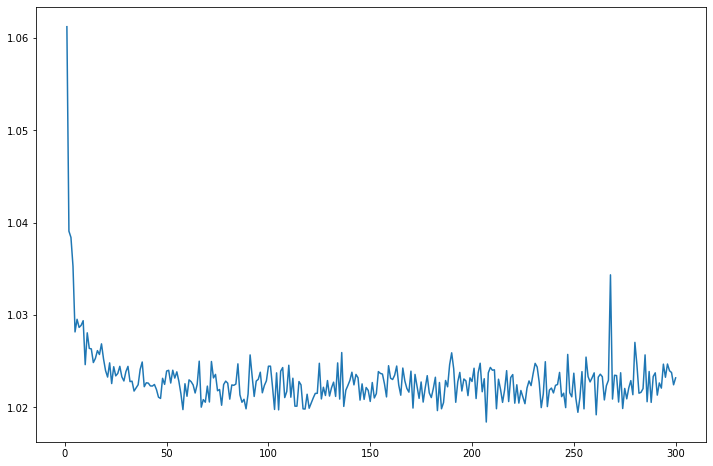

In [98]:
best_dnn_model.model.save_weights("dnn_weight.h5") #saving weight for later use
epochs_losses = history.history["loss"]
plt.plot([i for i in range(1,301)],epochs_losses)
plt.show()

In [100]:
dnn_pred = best_dnn_model.predict(np.array(stack_test[features_dnn]))
print("accuracy: ", accuracy_score(y_test,dnn_pred))
print("Precision: ", precision_score(y_test,dnn_pred))
print("Recall: ",recall_score(y_test,dnn_pred))
print("MCC: ",matthews_corrcoef(y_test,dnn_pred))

9419/9419 [==============================] - 0s 50us/step
accuracy:  0.6613228580528718
Precision:  0.9095637583892617
Recall:  0.6715807730426164
MCC:  0.19712308270397974


It seems like there is a slight disconnect between the training set + the validation set, and the test set (slightly overfitting). Although we have stratified them for the correct proportions of target, our data is too sensitive. Exploring various learning rates, batch sizes, hidden dimensions and activation functions, I have chosen on what I think as the "optimum" for speeding/result. It doesn't improve over the previous simple majority voting from our ensemble technique, but the dnn would be a good excercise looking at a stacking architecture. 

There are many ways to continue the project:revising features, choose another architecture for stacking, upsampling minority classes to rebalance the data. However, I am happy with the current result without the need for using too much computing power.

# Conclusion

We were able to generalize the dataset pretty well. This ensemble model is pretty decent with a 1/3 miss chance on good loan, but with a very high success rate on determining a good investment. Using F1-score optimization will make us use more risk with a high recall rate. MCC score takes into account of all 4 confusion matrix quadrants to help us not be too conservative if we had chosen to optimize for precision. 

Many real world data are not Guassian in nature, and can sometime be filled with useless features. It is neccessary to see how important the preparation and exploration of data. Using various techniques and optimize them with GridSearch helped our initial search. Just like the real world, we want to optimize on both research time and results. This makes us skip a couple of algorithms and neural networks related stuff. However, the most important aspect of the project was to figure out how to handle our business question, the characteristics of our dataset, as well as preparing the neccessary features to use.

Now the conclusion to our question is that with this model we can have a high rate of lending out good loans (if the borrower stays in the "known" zone - or we might want to expand the nearby customer profiles to help gather even more data). It is now our job to go out there and find 3-4 people for every 2 people on average, that we want to make money off of within this "known zone"!